# Collaboration and Competition

---
***Author: Yanxiang Yu***

***Date: April 17th, 2020***

We are going to use DDPG algorithm to train an muti-agent task- Unity Tennis.

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation with a total of 24 states. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores. This yields a single score for each episode.

Due to the multi-agent nature, the training process is very noisy and understable. However, after trained both agent for 2248 episodes, the agents achieve an average score of +0.75 (over 100 consecutive episodes, after taking the maximum over both agents).

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1450000023469329
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. Train the agents

Now it's time to train the agent to solve the environment! We are going to use DDPG algorithm to train the agent.

The detail of DDPG can be found in the paper by Timothy P. Lillicrap etc. This project is very similar to the Continuous Control project, except we'll create and train the two agents independently. 

The DDPG algorithm is an actor-critic, model-free algorithm based on the deterministic policy gradient that can operate over continuous action spaces. The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients), and the “Critic” estimates the value function, this could be the action-value (the Q value) or state-value (the V value). During the learning period, both "Actor" and "Critic" have two netowrks- one local network to update the training paramters, and one target network for evaluation of the performance. To update the local network, a soft update is introduced, which use 0.001 of the local network parameters, and 0.999 of the target paramters to update the target network. In addition, to enhance the exploration of the network, Ornstein-Uhlenbeck process is introduces as the noise term added to the actions.

Two agents are trained independently, each of them will receive they own states, rewards, next states, and will make their own actions respectively. 

In this agent network, we used a 2 hidden layer neural network for both "Actor" and "Critic" network, each layer has 256 and 128 nodes respectively. Other hyperparamters we used are:

* BUFFER_SIZE = int(1e6) # replay buffer size
* BATCH_SIZE = 128 # minibatch size
* GAMMA = 0.98 # discount factor
* TAU = 1e-3 # for soft update of target parameters
* LR_ACTOR = 1e-4 # learning rate of the actor
* LR_CRITIC = 1e-3 # learning rate of the critic
* WEIGHT_DECAY = 0 # L2 weight decay
* UPDATE_EVERY = 10 # how often to update the network
* UPDATE_TIMES = 20 # how many times to update the network each time
* EPSILON = 1.0 # epsilon for the noise process added to the actions
* EPSILON_DECAY = 1e-6 # decay for epsilon above

In [6]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

from workspace_utils import active_session # keep session active

In [7]:
agent1 = Agent(state_size=24, action_size=2, random_seed=2)
agent2 = Agent(state_size=24, action_size=2, random_seed=2)

Episode 100	Average Score: -0.002499999850988388
Episode 200	Average Score: -0.0049999998882412915
Episode 300	Average Score: -0.004999999888241291
Episode 400	Average Score: -0.004999999888241291
Episode 500	Average Score: -0.0044999998807907105
Episode 600	Average Score: 0.00700000029057264320
Episode 700	Average Score: 0.00050000019371509550
Episode 800	Average Score: -0.0019999998435378074
Episode 900	Average Score: -0.0049999998882412915
Episode 1000	Average Score: -0.004999999888241291
Episode 1100	Average Score: -0.004999999888241291
Episode 1200	Average Score: 0.02000000048428774720
Episode 1300	Average Score: 0.036950000738725064
Episode 1400	Average Score: 0.026500000581145287
Episode 1500	Average Score: 0.021500000506639482
Episode 1600	Average Score: 0.019500000476837157
Episode 1700	Average Score: 0.039000000767409826
Episode 1800	Average Score: 0.034350000703707334
Episode 1900	Average Score: 0.052000000961124925
Episode 2000	Average Score: 0.064000001149252066
Episode 21

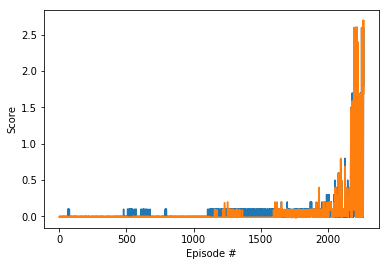

In [12]:
def maddpg(n_episodes=5000, reset_time=100, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent1.reset()
        agent2.reset()
        #for t in range(max_t):
        while True:
            action1 = agent1.act(np.expand_dims(states[0], axis=0))
            action2 = agent2.act(np.expand_dims(states[1], axis=0))
            actions = np.vstack((action1, action2))
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent1.step(states[0], action1, rewards[0], next_states[0], dones[0])
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            score += rewards                                   # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {}'.format(i_episode, np.mean(scores_deque)))
        # Keep higher threshold during training
        if np.mean(scores_deque) > (0.8):
            print('\nEnvironment solved in {} episodes.\tAverage Score: {}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent1.actor_local.state_dict(), 'agent1_checkpoint_actor.pth')
            torch.save(agent1.critic_local.state_dict(), 'agent1_checkpoint_critic.pth')
            torch.save(agent2.actor_local.state_dict(), 'agent2_checkpoint_actor.pth')
            torch.save(agent2.critic_local.state_dict(), 'agent2_checkpoint_critic.pth')
            break
            
    return scores

with active_session():
    # do long-running work here
    scores = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
agent1.actor_local.load_state_dict(torch.load('agent1_checkpoint_actor.pth'))
agent1.critic_local.load_state_dict(torch.load('agent1_checkpoint_critic.pth'))
agent2.actor_local.load_state_dict(torch.load('agent2_checkpoint_actor.pth'))
agent2.critic_local.load_state_dict(torch.load('agent1_checkpoint_critic.pth'))

In [ ]:
# Run the agent for 100 times
with active_session():
    scores100 = []
    for i in range(1, 101):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        zz = 0
        while True:
            zz += 1
            action1 = agent1.act(np.expand_dims(states[0], axis=0))
            action2 = agent2.act(np.expand_dims(states[1], axis=0))
            actions = np.vstack((action1, action2))
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                print('\rEpisode {}\ttotal steps: {:.2f}'.format(i, zz))
                break

        scores100.append(scores)

        if i % 10 == 0:
            print('\rEpisode {}\tScore: {:.2f}'.format(i, np.mean(scores100)))


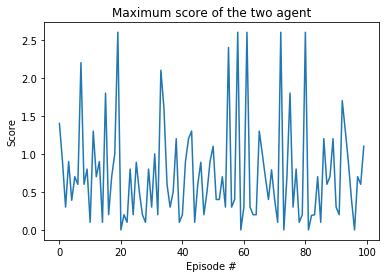

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(100), np.max(scores100, axis=1))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Maximum score of the two agent')
plt.show()

In [23]:
print('The maximum score after 100 episodes is:', np.mean(np.max(scores100, axis=1)))

The maximum score after 100 episodes is: 0.747300011162


### 5. Summay and Future Work
In this notebook, we used DDPG algorithm to train the multi-agent task: Unity Tennis. two independent agents were trained in the environment to play with each other. The training process is noisy and unstable, the first 2000 episode we achieved almost nothing. However, after 2268 episode, we achieved a very good score of 0.74 for 100 episode average. 

To further improving the agent's performance, we can further training the agent with different hyper-parameters, such as tune the parameters of the network, add dropout layers, change the noise value, batch size, discount factor or update frequency, and so on. In addtion, We can try some other more advanced techniques, including:

* Prioritized Experience Replay: by add importance to the recycled trajactories, and sample them with the probability by their importance
* PPO: proximal Policy Optimization algorithm
* A2C: Advatage Actor Critic algorithm
* GAE: Generalized Advantage Estimation algorithm


We can also try to see if the two agents can share the same reply buffer to increase the learning capability, and also save memory. 